In [1]:
import os
import sys
import time
import optparse
import configparser
import pyodbc
import pandas as pd
import numpy as np
import datetime
#import holidays
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
temp_space = pd.read_excel('./datasets/88688_gap_15min_space_temp_f18_csw.xlsx')
temp_weather = pd.read_excel('./datasets/68364_gap_1h_weather_temp.xlsx')

df_weather=pd.DataFrame(np.array(temp_weather),columns=['Run_DateTime','Date','UTC_Date','TempA','TempM',
                                                        'DewPointA','DewPointM' ,'Humidity' ,'WindSpeedA',
                                                        'WindSpeedM' ,'WindGustA' ,'WindGustM' ,'WindDir',
                                                        'VisibilityA' ,'VisibilityM' ,'PressureA' ,'PressureM',
                                                        'WindChillA' ,'WindChillM' ,'HeatIndexA' ,'HeatIndexM',
                                                        'PrecipA' ,'PrecipM' ,'Condition' ,'Fog' ,'Rain',
                                                        'Snow' ,'Hail' ,'Thunder','Tornado' ,'ID'])
df_weather = df_weather[['Date','TempM','DewPointM','Humidity','WindSpeedM' ,'PressureM']]

df_space = pd.DataFrame(np.array(temp_space),columns=['ID','zone','floor','quadrant','eq_no','Date','temp'])

In [3]:
def time_process(date):
    time=datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S.0000000')
    return datetime.datetime(time.year,time.month,time.day,time.hour)

def weather_data_feature_selected_and_serialize(df_weather):
    cols=['TempM','DewPointM','Humidity','WindSpeedM' ,'PressureM']
    for col in cols:
        df_weather = df_weather.loc[~(df_weather[col] == 'N/A')]
        df_weather = df_weather.loc[~(df_weather[col] == -9999)]
    date_trans=lambda date:datetime.datetime(date.year, date.month, date.day, date.hour)
    df_weather['time']=df_weather['Date'].apply(date_trans)
    df_weather = df_weather.dropna()
    df_weather.drop('Date',axis=1,inplace=True)
    result = df_weather.groupby('time').apply(np.mean)
    return result

def weather_data_interpolation(df_weather):
    interpolate_sample = df_weather.resample('15Min').asfreq()
    df_weather_interpolated = interpolate_sample.interpolate(method='time')
    return df_weather_interpolated

def space_temp_data_feature_selected_and_serialize(df_space):
    cols=['Date','temp']
    df_space = df_space[cols]
    df_space = df_space.dropna()
    date_trans=lambda date:datetime.datetime(date.year, date.month, date.day, date.hour, date.minute)
    df_space['time'] = df_space['Date'].apply(date_trans)
    df_space.drop('Date', axis=1, inplace=True)
    result = df_space.groupby('time').apply(np.mean)
    return result

def space_temp_extreme_data_clean_up(df_space, bad_values, verbose):
    df_space_cleaned = df_space.copy()
    
    clean_up_temp = []
    
    for bad_value in bad_values:
        for i in df_space.loc[df_space['temp'] == bad_value].index:
            clean_up_temp.append((df_space_cleaned.loc[i]))
            df_space_cleaned = df_space_cleaned.drop(i)
    
    if(verbose == True):
        show_interpolation_data_range(clean_up_temp)
    
    return df_space_cleaned

def space_temp_data_interpolation(df_space):
    interpolate_sample = df_space.resample('15Min').asfreq()
    df_space_interpolated = interpolate_sample.interpolate(method='time')
    return df_space_interpolated

def weather_data_preprocess(df_weather, bad_values=[0, 162.8, 250]):
    df_weather_serial = weather_data_feature_selected_and_serialize(df_weather)
    df_weather_serial_interpolated = weather_data_interpolation(df_weather_serial)    
    return df_weather_serial_interpolated
    
def space_temp_data_preprocess(df_space, bad_values=[0, 162.8, 250], verbose=False):
    df_space_serial = space_temp_data_feature_selected_and_serialize(df_space)
    df_space_serial_cleaned = space_temp_extreme_data_clean_up(df_space_serial, bad_values, verbose)
    df_space_serial_interpolated = space_temp_data_interpolation(df_space_serial_cleaned)
    
    return df_space_serial_interpolated

# In case people want to check the data after preprocessing
def write_data_to_excel(dataframe, filename):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    dataframe.to_excel(writer, sheet_name='Sheet1')

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
# cleanning data printer
def show_interpolation_data_range(clean_up_list):
    bad_data_counter = {}
    
    for i, row in enumerate(clean_up_list):
        print(  'Temp: %s   '%(row['temp']), 'Date:', row.name)
        if(str(row['temp']) not in bad_data_counter):
            bad_data_counter[str(row['temp'])] = 1
        else:
            bad_data_counter[str(row['temp'])] += 1
    
    # Print counter
    for key, value in bad_data_counter.items():
        print('Clean up %s bad data(%s)' %(value, key))

In [4]:
df_weather_processed = weather_data_preprocess(df_weather)
df_space_processed = space_temp_data_preprocess(df_space, bad_values=[0, 162.8, 250], verbose=False)
#write_data_to_excel(df_space_processed, 'space_data.xlsx')

In [5]:
df = pd.merge(df_weather_processed, df_space_processed, left_index=True, right_index=True)

In [6]:
df.describe()

,TempM,DewPointM,Humidity,WindSpeedM,PressureM,temp
count,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000
mean,12.980013,5.007351,61.041433,8.613126,1016.870510,75.989889
std,10.102947,10.978114,18.255298,5.335288,7.650253,1.991362
min,-15.600000,-26.700000,13.000000,0.000000,966.566667,67.802124
25%,4.400000,-3.600000,47.000000,5.600000,1011.883333,74.566101
50%,13.900000,6.100000,59.500000,8.325000,1016.850000,75.586365
75%,21.700000,14.150000,75.000000,11.150000,1021.764583,76.946655
max,36.700000,24.233333,100.000000,42.566667,1041.600000,87.527222


In [7]:
scaler = MinMaxScaler((0,1))
def get_batch(df, batch_size=128, T=16, input_dim=6, step=0, train=True, forecast_dim=24):
    
    t = step * batch_size
    X_batch = np.empty(shape=[batch_size, T, input_dim])
    y_batch = np.empty(shape=[batch_size, T])
    labels = np.empty(shape=[batch_size])
    forecast_labels = np.empty(shape=[batch_size, forecast_dim])
    #time_batch = np.empty(shape=[batch_size, T], dtype='datetime64')
    time_batch = np.array([])
    time_stamp = df.index.tolist()
    
    for i in range(batch_size):
        X_batch[i, :] = scaler.fit_transform(df.iloc[t:t+T].values)
        y_batch[i, :] = df["temp"].iloc[t:t+T].values
        labels[i] = df["temp"].iloc[t+T]
        forecast_labels[i, :] = df["temp"].iloc[t:t+forecast_dim].values
        time_batch = np.append(time_batch, time_stamp[t+T])
        #time_batch[i, :] = df.iloc[t:t+T].index[-1]
        
        t += 1     
    
    ## shuffle in train, not in test
    if train:
        index = list(range(batch_size))
        np.random.shuffle(index)
        X_batch = X_batch[index]
        y_batch = y_batch[index]
        labels = labels[index]
        forecast_labels = forecast_labels[index]
        time_batch = time_batch[index]

    return X_batch, y_batch, labels, forecast_labels, time_batch

In [8]:
x, y, labels, forecast_labels, time_train = get_batch(df,batch_size = 256, T = 7*24, step = 50, train=True)

In [9]:
print(x.shape)
print(y.shape)
print(labels.shape)
print(forecast_labels.shape)
print(time_train.shape)

(256, 168, 6)
(256, 168)
(256,)
(256, 24)
(256,)


In [10]:
class ts_prediction(object):
    
    def __init__(self, input_dim, time_step, n_hidden, d_hidden, batch_size, forecast_dim):

        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.d_hidden = d_hidden
        #self.o_hidden = 16
        
        self.input_dim = input_dim
        self.time_step = time_step
        self.forecast_dim = forecast_dim
        
        self.seq_len = tf.placeholder(tf.int32,[None])
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, None, input_dim]) # b,T,d_in
        self.input_y = tf.placeholder(dtype = tf.float32,shape = [None,self.time_step]) # b,T
        self.forecast_y = tf.placeholder(dtype = tf.float32,shape = [None, self.forecast_dim]) # b,forecast_dim
        self.label = tf.placeholder(dtype = tf.float32) #b,1
        self.original_loss = tf.placeholder(dtype = tf.float32, shape = [])
        ## placeholder for loss without adversarial gradient added
        
        self.encode_cell = tf.contrib.rnn.LSTMCell(self.n_hidden, forget_bias=1.0, state_is_tuple=True)
        self.decode_cell = tf.contrib.rnn.LSTMCell(self.d_hidden, forget_bias=1.0, state_is_tuple=True)
        #self.output_cell = tf.contrib.rnn.LSTMCell(self.o_hidden, forget_bias=1.0, state_is_tuple=True)
        
        self.loss_1 = tf.constant(0.0)
        self.loss = tf.constant(0.0)
        ## ===========  build the model =========== ##
            
        ## ==== encoder ===== ## 
        h_encode, c_state = self.en_RNN(self.input_x)#!!!!!!!
        c_expand = tf.tile(tf.expand_dims(c_state[1],1),[1,self.time_step,1])
        fw_lstm = tf.concat([h_encode,c_expand],axis = 2) # b,T,2n
        stddev = 1.0/(self.n_hidden*self.time_step)
        Ue = tf.get_variable(name= 'Ue',dtype = tf.float32,
                             initializer = tf.truncated_normal(mean = 0.0, stddev = stddev,shape = [self.time_step,self.time_step]))
        ## (b,d,T) * (b,T,T)  = (b,d,T)
        brcast_UX = tf.matmul(tf.transpose(self.input_x,[0,2,1]),tf.tile(tf.expand_dims(Ue,0),[self.batch_size,1,1]))
        e_list = []
        for k in range(self.input_dim):
            feature_k = brcast_UX[:,k,:] 
            e_k = self.en_attention(fw_lstm,feature_k) # b,T 
            e_list.append(e_k)
        e_mat = tf.concat(e_list,axis = 2)
        alpha_mat = tf.nn.softmax(e_mat) #b,T,d_in horizontally
        encode_input = tf.multiply(self.input_x,alpha_mat)
        self.h_t, self.c_t = self.en_RNN(encode_input, scopes = 'fw_lstm')

        self.encoder_state = tf.concat([self.c_t[0], self.c_t[1]], 1)
        
        ## ==== inferrence nn ==== ##
        """
        encoder_shape = self.encoder_state.get_shape().as_list()
        node_input_layer = encoder_shape[1]
        node_hidden_layer1 = encoder_shape[1] * 6 * 4
        node_hidden_layer2 = encoder_shape[1] * 6 * 2
        node_hidden_layer3 = encoder_shape[1] * 6
        node_output_layer = self.forecast_dim
        W_h1 = tf.get_variable(name = 'W_h1', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_input_layer, node_hidden_layer1]))
        W_h2 = tf.get_variable(name = 'W_h2', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_hidden_layer1, node_hidden_layer2]))
        W_h3 = tf.get_variable(name = 'W_h3', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_hidden_layer2, node_hidden_layer3]))
        W_out = tf.get_variable(name = 'W_out', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_hidden_layer3, node_output_layer]))
        b_h1 = tf.get_variable(name = 'b_h1', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_hidden_layer1]))
        b_h2 = tf.get_variable(name = 'b_h2', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_hidden_layer2]))
        b_h3 = tf.get_variable(name = 'b_h3', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_hidden_layer3]))
        b_out = tf.get_variable(name = 'b_out', dtype = tf.float32,initializer = tf.truncated_normal(mean=0.0, stddev=stddev,shape=[node_output_layer]))
        
        layer1 = tf.add(tf.matmul(self.encoder_state, W_h1), b_h1)
        layer1 = tf.nn.relu(layer1)

        layer2 = tf.add(tf.matmul(layer1, W_h2), b_h2)
        layer2 = tf.nn.relu(layer2)

        layer3 = tf.add(tf.matmul(layer2, W_h3), b_h3)
        layer3 = tf.nn.relu(layer3)

        output = tf.add(tf.matmul(layer3, W_out), b_out)
        
        self.forecast_y_pred = output
        self.forecast_loss = tf.reduce_mean(tf.pow((self.forecast_y_pred - self.forecast_y), 2))
        self.forecast_optimizer = tf.train.AdamOptimizer(0.001)
        self.logit_op = self.forecast_optimizer.minimize(self.forecast_loss)
        """
        ## ==== decoder ===== ## 
        h_decode, d_state = self.de_RNN(tf.expand_dims(self.input_y,-1))
        
        d_expand = tf.tile(tf.expand_dims(d_state[1],1),[1,self.time_step,1])
        dec_lstm = tf.concat([h_decode,d_expand],axis = 2) # b,T,2*d_hidden

        Ud = tf.get_variable(name = 'Ud', dtype = tf.float32,
                             initializer = tf.truncated_normal(mean = 0.0, stddev = stddev, shape = [self.n_hidden, self.n_hidden]))
        
        brcast_UDX = tf.matmul(self.h_t,tf.tile(tf.expand_dims(Ud,0),[self.batch_size,1,1])) # b,T,n_hidden
        
        l_list = []
        for i in range(self.time_step):
            feature_i = brcast_UDX[:,i,:]
            l_i = self.dec_attention(dec_lstm,feature_i)
            l_list.append(l_i)
        l_mat = tf.concat(l_list,axis = 2)
        beta_mat = tf.nn.softmax(l_mat, dim = 1)
        context_list = []
        h_tmp = tf.transpose(self.h_t,[0,2,1])

        for t in range(self.time_step):
            beta_t = tf.reshape(beta_mat[:,t,:],[self.batch_size,1,self.time_step])
            self.c_t = tf.reduce_sum(tf.multiply(h_tmp,beta_t),2) # b,T,T -> b,T,1
            context_list.append(self.c_t)
        c_context = tf.stack(context_list,axis = 2) # b,n_hidden,T
        # b,T,1 b,T,n_hidden -> b,T,n_hidden+1
        c_concat = tf.concat([tf.expand_dims(self.input_y,-1),tf.transpose(c_context,[0,2,1])], axis = 2)
        W_hat = tf.get_variable(name = 'W_hat', dtype = tf.float32,
                                initializer = tf.truncated_normal(mean = 0.0, stddev = stddev,shape = [self.n_hidden+1,1]))
        y_encode = tf.matmul(c_concat,tf.tile(tf.expand_dims(W_hat,0),[self.batch_size,1,1]))
        
        
        h_out, d_out = self.de_RNN(y_encode)
        
        #last_concat = tf.expand_dims(tf.concat([h_out[:,-1,:],d_out[-1]],axis = 1),1)
        Wy = tf.get_variable(name = 'Wy', dtype = tf.float32,initializer = tf.truncated_normal(mean = 0.0, stddev = stddev,shape = [self.d_hidden,1]))
        W_y = tf.tile(tf.expand_dims(Wy,0),[self.batch_size,1,1])
        self.y_predict = tf.squeeze(tf.matmul(h_out,W_y))
        #self.loss += tf.reduce_mean(tf.square(self.label - self.y_predict)) # reduce_mean: avg of batch loss
        
        self.loss_1 += tf.reduce_mean(tf.square(self.forecast_y - self.y_predict)) # reduce_mean: avg of batch loss
        self.adversarial_gradient = tf.gradients(self.loss_1,self.input_x)
        
        self.loss = self.loss_1 + self.original_loss
        
        self.params = tf.trainable_variables()
        
        #learning rate
        self.alpha=tf.Variable(5e-4)
        optimizer = tf.train.AdamOptimizer(self.alpha)
        
        
        #self.train_op = optimizer.minimize(self.loss)
        grad_var = optimizer.compute_gradients(loss = self.loss, var_list = self.params, aggregation_method = 2)
        self.train_op = optimizer.apply_gradients(grad_var)
        
        
    def en_RNN(self, input_x, scopes = 'fw_lstm'):
        '''
        input_x: b, T, d_in
        
        output: h:       seqence of output state b,T,n_hidden
                state:   final state b,n_hidden
                
        '''
        with tf.variable_scope('fw_lstm' or scopes) as scope:
            try:
                h,state = tf.nn.dynamic_rnn(
                    cell = self.encode_cell, inputs = input_x,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = 'fw_lstm')
                
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(
                    cell = self.encode_cell, inputs = input_x,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def de_RNN(self,input_y, scopes = 'de_lstm'):
        
        with tf.variable_scope('dec_lstm') as scope:
            try:
                h,state = tf.nn.dynamic_rnn(
                    cell = self.decode_cell, inputs = input_y,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = 'de_lstm')
                
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(
                    cell = self.decode_cell, inputs = input_y,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def en_attention(self,fw_lstm,feature_k):
        '''
        fw_lstm: b,T,2n
        feature_k: row k from brcast_UX, b,T
        
        return: b,T
        '''
        with tf.variable_scope('encoder') as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                We = tf.get_variable(name = 'We', dtype=tf.float32,shape = [self.time_step, 2*self.n_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Ve = tf.get_variable(name = 'Ve',dtype=tf.float32,shape = [self.time_step,1],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                We = tf.get_variable('We')
                Ve = tf.get_variable('Ve')   
            # (b,T,2n) (b,2n,T)
        W_e = tf.transpose(tf.tile(tf.expand_dims(We,0),[self.batch_size,1,1]),[0,2,1]) # b,2n,T
        mlp = tf.nn.tanh(tf.matmul(fw_lstm,W_e) + tf.reshape(feature_k,[self.batch_size,1,self.time_step])) #b,T,T + b,1,T = b,T,T
        V_e = tf.tile(tf.expand_dims(Ve,0),[self.batch_size,1,1])
        return  tf.matmul(mlp,V_e)
            
    def dec_attention(self, dec_lstm, feature_t, scopes = None):
        '''
        dec_lstm: b,T,2*d_hidden
        feature_k: row k from brcast_UX, b,T
        
        return: b,T
        '''
        with tf.variable_scope('decoder' or scopes) as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                Wd = tf.get_variable(name = 'Wd', dtype=tf.float32, shape = [self.n_hidden, 2*self.d_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Vd = tf.get_variable(name = 'Vd', dtype=tf.float32, shape = [self.n_hidden,1],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                Wd = tf.get_variable('Wd')
                Vd = tf.get_variable('Vd')   
        # (b,T,2*d_hidden) (b,2*d_hidden,T)
        W_d = tf.transpose(tf.tile(tf.expand_dims(Wd,0),[self.batch_size,1,1]),[0,2,1]) # b,2*d_hidden,n_hidden
        # (b,T,2*d_hidden) * (b,2*d_hidden,n_hidden) -> b,T,n_hidden
        mlp = tf.nn.tanh(tf.matmul(dec_lstm,W_d) + tf.reshape(feature_t,[self.batch_size,1,self.n_hidden])) #b,T,n_hidden + b,1,n_hidden = b,T,n_hidden
        V_d = tf.tile(tf.expand_dims(Vd,0),[self.batch_size,1,1])
        return  tf.matmul(mlp,V_d) #b,T,1
    
    def predict(self,x_test,y_test,sess):
        
        train_seq_len =  np.ones(self.batch_size) * self.time_step
        feed = {model.input_x: x_test, 
                model.seq_len: train_seq_len,
                model.input_y: y_test}
        y_hat = sess.run(self.y_predict, feed_dict = feed)
        return y_hat
    
    def forecast(self, x_test, forecast_test, sess):
        train_seq_len =  np.ones(self.batch_size) * self.time_step
        feed = {model.input_x: x_test, 
                model.seq_len: train_seq_len,
                model.forecast_y: forecast_test}
        y_hat = sess.run(self.forecast_y_pred, feed_dict = feed)
        return y_hat

In [11]:
w_data=df
batch_size = 7 * 24 * 4 * 4
INPUT_DIM = 6 # input feature
FORECAST_DIM = 24 # forecast dimension
# time_steps = 7*24 
time_steps = 24 
n_hidden = 64 # encoder dim
d_hidden = 64 # decoder dim

total_epoch = 1000

train_batch_num = int(len(w_data)*0.8/batch_size) ## 0.8 of traininng data, 20% for testing

df_test = w_data[(train_batch_num*batch_size):]
df1 = w_data[:(train_batch_num*batch_size)]

steps_train = int((len(df1) - time_steps)/batch_size) - 1
steps_test = int((len(df_test) - time_steps)/batch_size) - 1

print ('Training data %i' % len(df1), "testing data %i" % len(df_test))

Training data 72576 testing data 20623


In [12]:
# Check everything before training model
print(steps_train)
print(steps_test)

print(w_data.shape)
print(df_test.shape)
print(df1.shape)

x, y, labels, forecast, times = get_batch(df1,batch_size = batch_size, T = time_steps, step = steps_train-1)
print(x.shape)
print(y.shape)
print(forecast.shape)
print(labels.shape)
print(times.shape)

25
6
(93199, 6)
(20623, 6)
(72576, 6)
(2688, 24, 6)
(2688, 24)
(2688, 24)
(2688,)
(2688,)


## LSTM Pre-train

In [13]:
current_epoch = 0
tf.reset_default_graph()

model = ts_prediction(input_dim=INPUT_DIM, time_step=time_steps, n_hidden=n_hidden, d_hidden=d_hidden, batch_size=batch_size, forecast_dim=FORECAST_DIM)
init = tf.global_variables_initializer()

#memory policy
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(init)

while current_epoch <= total_epoch:
    cumulative_loss = 0.0
    start_time = time.time()
    
    for t in range(steps_train - 1):
        x, y, labels, forecast_labels, _ = get_batch(df1,batch_size=batch_size, T=time_steps, step=t)
        train_seq_len =  np.ones(batch_size) * time_steps
        feed = {model.input_x: x, 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels,
                model.forecast_y: forecast_labels,
                }
        loss_1, adversarial_gradients, _ = sess.run([model.loss_1,model.adversarial_gradient, model.alpha],feed_dict = feed)
        
        epsilon = np.random.uniform(0,0.5,1)
        
        feed = {model.input_x: x + epsilon*adversarial_gradients[0], 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels,
                model.forecast_y: forecast_labels,
                model.original_loss: loss_1,
                }
        loss, _, _ = sess.run([model.loss, model.train_op, model.alpha], feed_dict = feed)
        
        cumulative_loss += loss
        
    end_time = time.time()
        
    print("time:%.1f epoch:%i/%i loss:%f" % (end_time - start_time, current_epoch, total_epoch, cumulative_loss))
    if cumulative_loss<3:
        if cumulative_loss>2.5:
            update=tf.assign(model.alpha,1e-4) #update the learning rate
            sess.run(update)
            print('Learning rate is updated to 1e-4')
        else:
            update=tf.assign(model.alpha,1e-5) #update the learning rate
            sess.run(update)
            print('Learning rate is updated to 1e-5')

    current_epoch += 1

time:95.3 epoch:0/1000 loss:278062.495117
time:93.0 epoch:1/1000 loss:274259.278320
time:93.8 epoch:2/1000 loss:265337.453125
time:93.7 epoch:3/1000 loss:255972.958008
time:93.1 epoch:4/1000 loss:247709.200195
time:92.8 epoch:5/1000 loss:240526.745117
time:93.3 epoch:6/1000 loss:233928.312500
time:93.8 epoch:7/1000 loss:227755.295898
time:93.4 epoch:8/1000 loss:221908.363281
time:93.5 epoch:9/1000 loss:216318.741211
time:93.6 epoch:10/1000 loss:210942.512695
time:93.3 epoch:11/1000 loss:205749.008789
time:93.4 epoch:12/1000 loss:200716.871094
time:93.7 epoch:13/1000 loss:195831.511719
time:93.8 epoch:14/1000 loss:191081.288086
time:93.5 epoch:15/1000 loss:186454.416992
time:93.2 epoch:16/1000 loss:181940.942383
time:93.1 epoch:17/1000 loss:177532.819824
time:93.8 epoch:18/1000 loss:173224.067871
time:93.1 epoch:19/1000 loss:169010.954102
time:93.1 epoch:20/1000 loss:164890.415527
time:92.5 epoch:21/1000 loss:160859.917480
time:92.8 epoch:22/1000 loss:156915.949707
time:93.4 epoch:23/10

## Prediction on test data

In [14]:
test_loss_decoder_forecast = 0.0
y_hat_arr_decoder_forecast = np.empty(shape = [0, 24])
y_labels_arr_decoder_forecast  = np.empty(shape = [0, 24])
time_batch_decoder_forecast = np.empty(shape = [0], dtype="str")


for t in range(steps_test-1):
    x_test_decoder_forecast, y_test_decoder_forecast, _, decoder_forecast_labels_test, time_test_decoder_forecast = get_batch(df_test, batch_size=batch_size, T=time_steps, step=t, train=False)   
    y_hat_decoder_forecast = model.predict(x_test_decoder_forecast, decoder_forecast_labels_test, sess) 
    y_hat_arr_decoder_forecast = np.concatenate([y_hat_arr_decoder_forecast, np.array(y_hat_decoder_forecast)])
    y_labels_arr_decoder_forecast = np.concatenate([y_labels_arr_decoder_forecast, np.array(decoder_forecast_labels_test)])
    time_batch_decoder_forecast = np.concatenate([time_batch_decoder_forecast, time_test_decoder_forecast])
    test_loss_decoder_forecast += np.mean(np.square(y_hat_decoder_forecast - decoder_forecast_labels_test))

print ("the mean squared error for test data are %f " % (test_loss_decoder_forecast * 1.0 / steps_test))


the mean squared error for test data are 0.376426 


In [15]:
print(y_labels_arr_decoder_forecast.shape)
print(y_hat_arr_decoder_forecast.shape)
print(time_batch_decoder_forecast.shape)

(13440, 24)
(13440, 24)
(13440,)


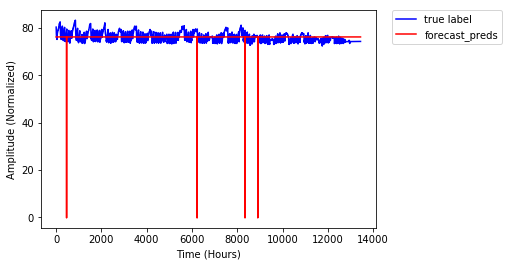

In [16]:
# Forecast 24 hours plot
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

plt.plot(y_labels_arr_decoder_forecast[:, 0], 'blue', label="true label")
plt.plot(y_hat_arr_decoder_forecast[:, 0], 'red', label="forecast_preds")
plt.xlabel('Time (Hours)')
plt.ylabel('Amplitude (Normalized)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

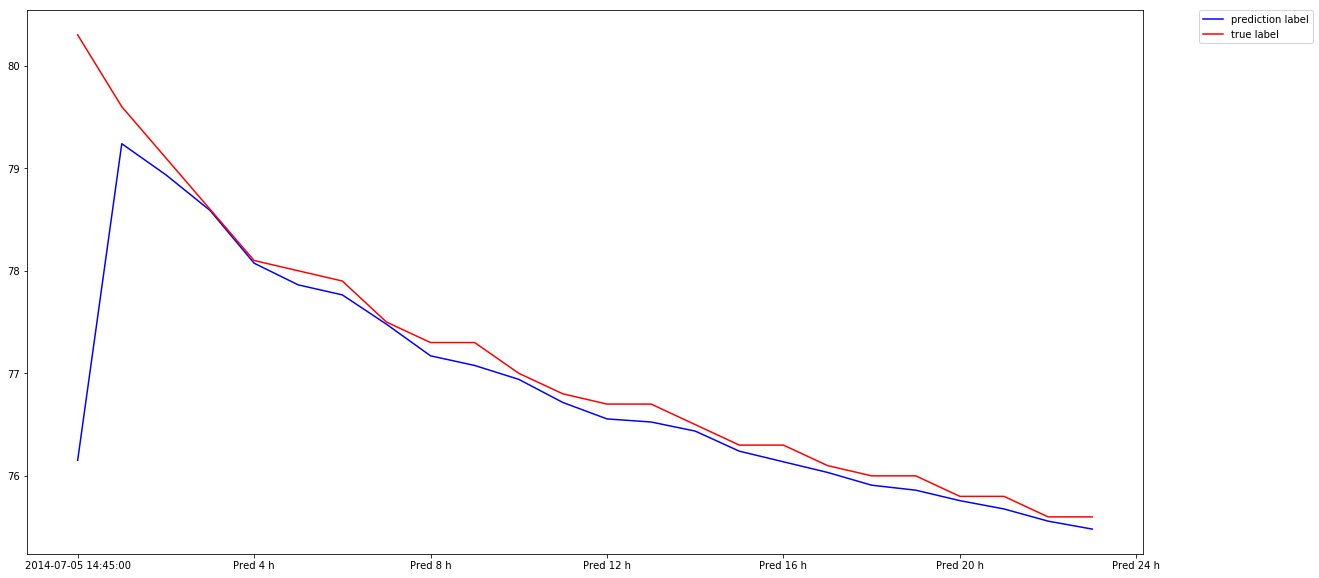

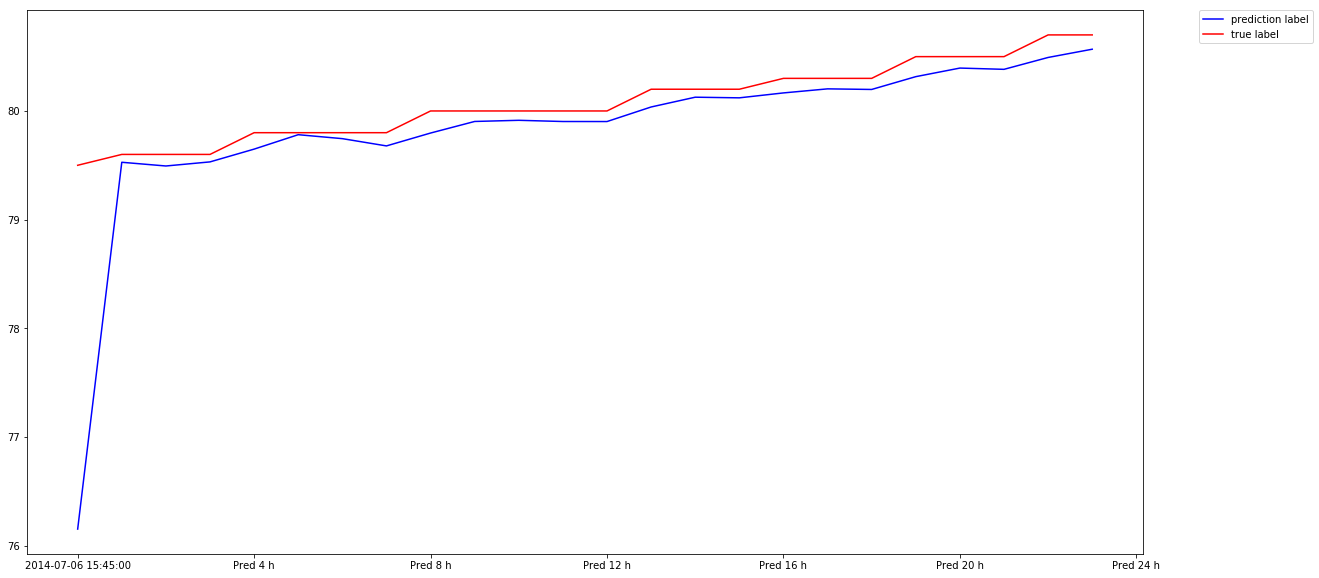

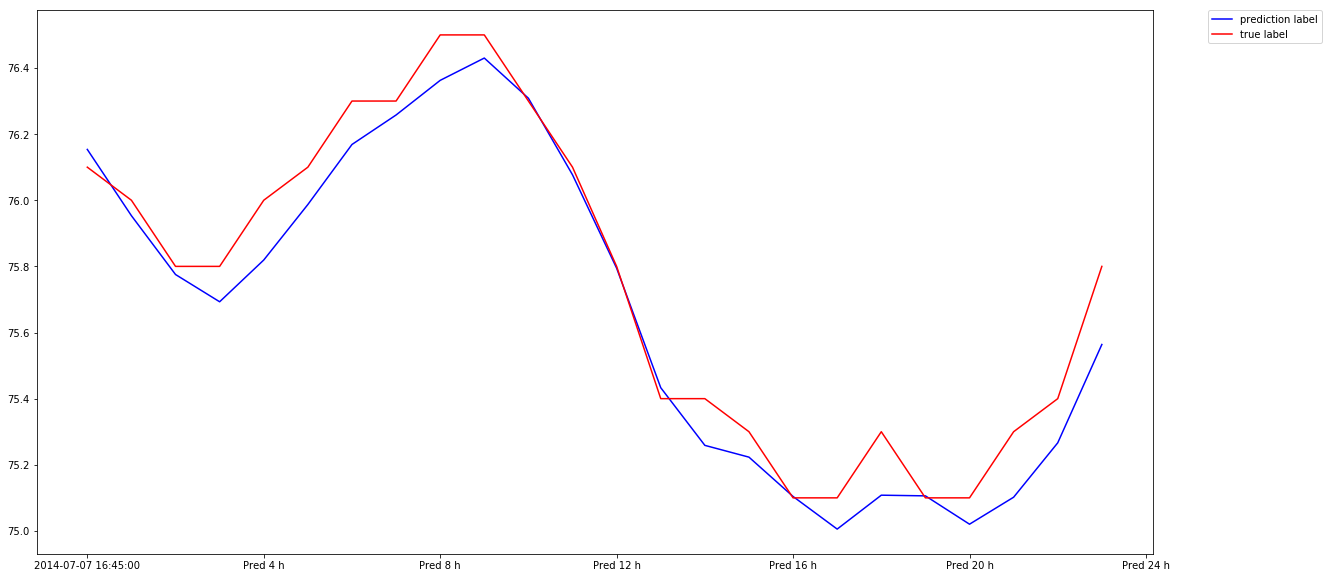

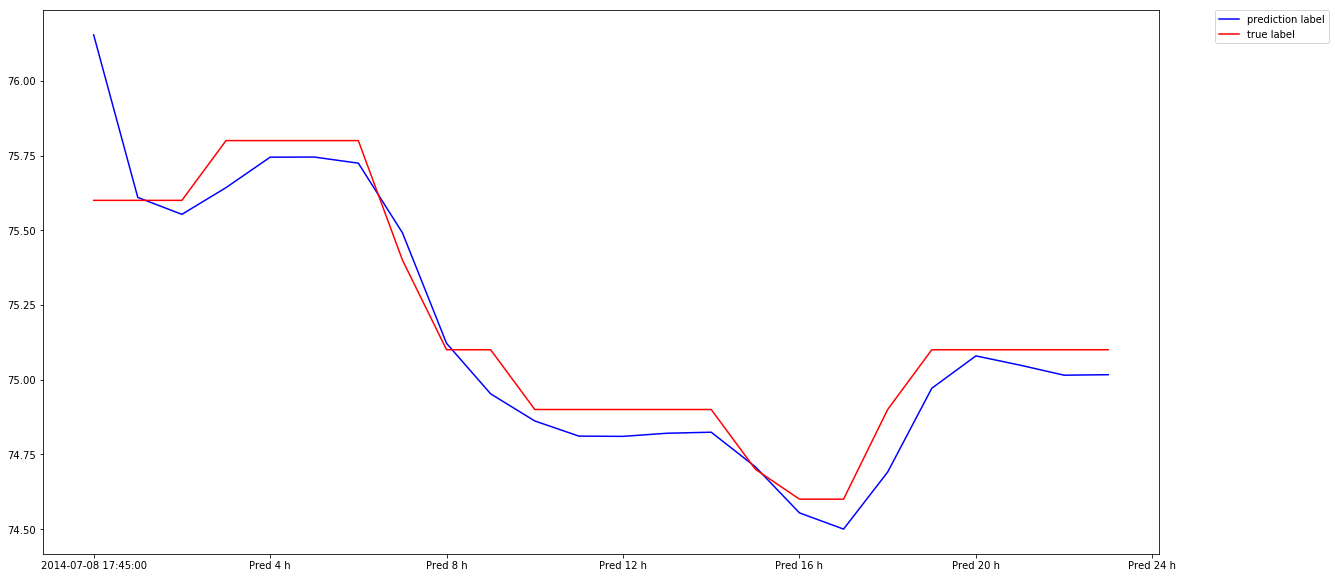

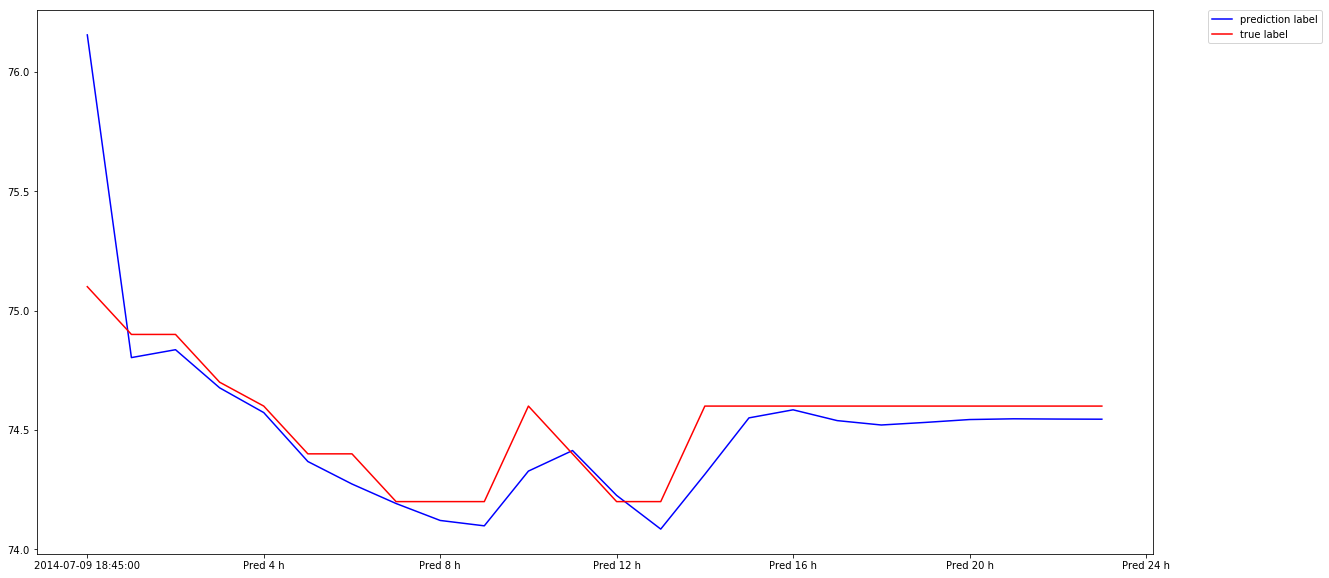

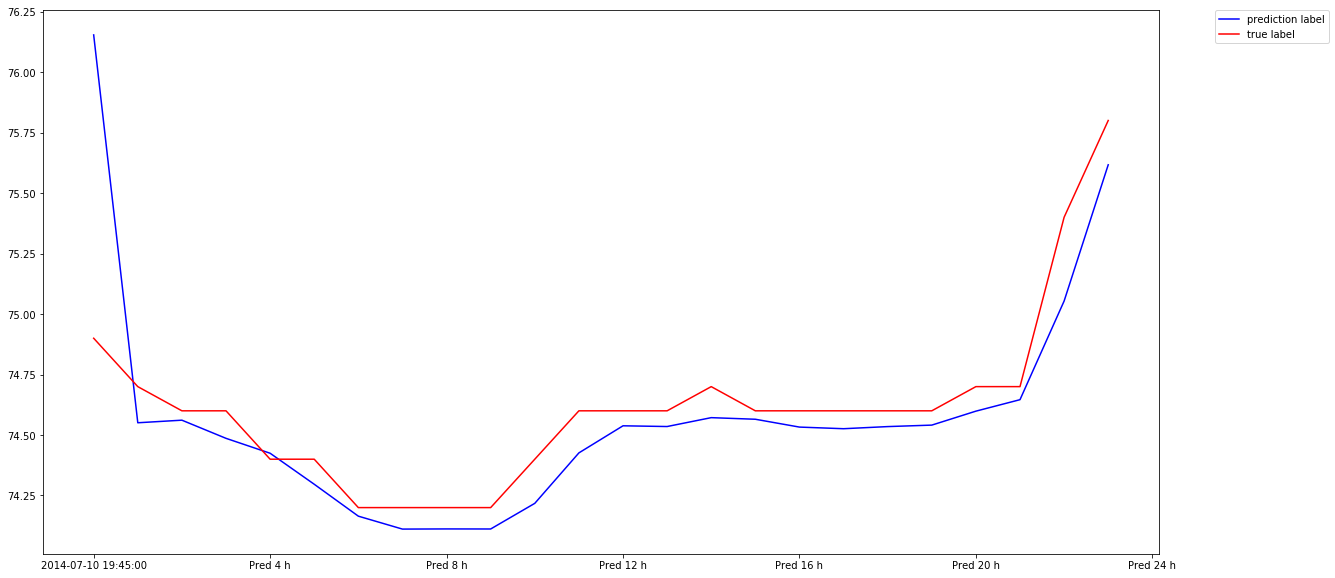

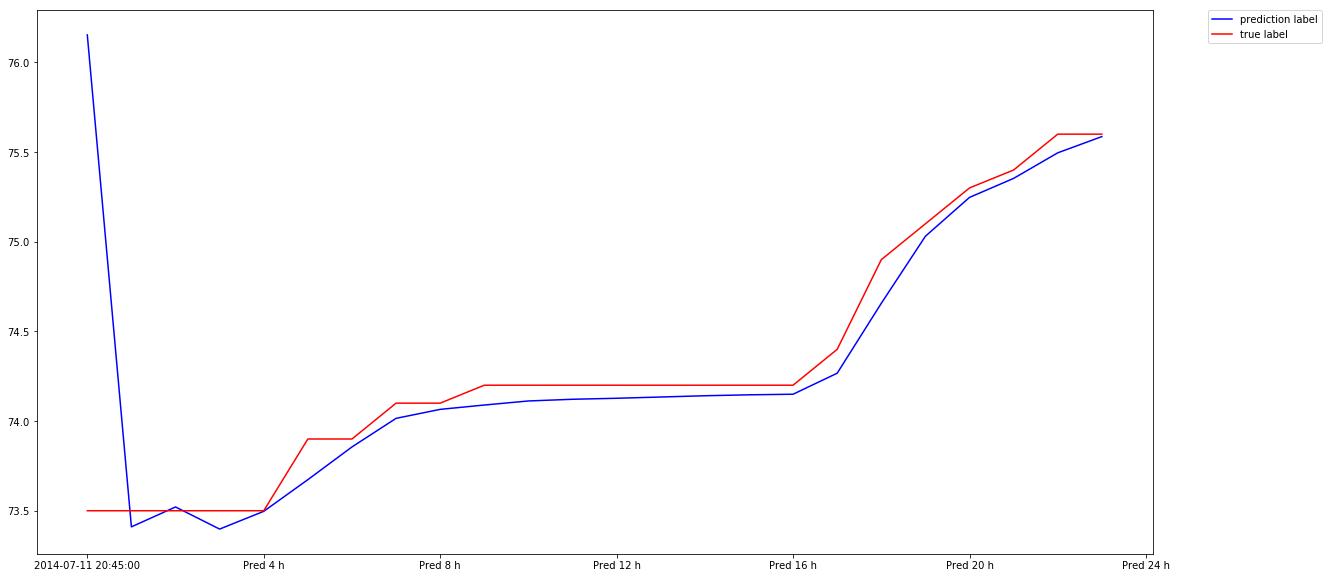

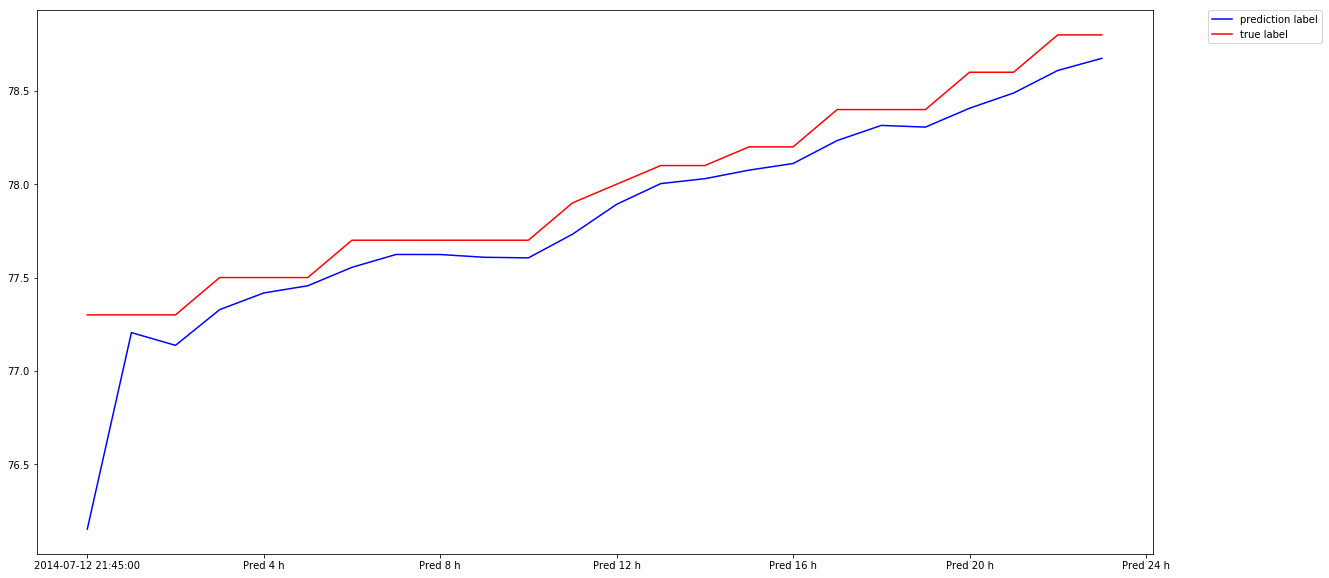

In [17]:
# Forecast 24 hours plot
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

_FUTURE_HOURS = y_hat_arr_decoder_forecast.shape[1]
compare_data_index = [0, 100, 200, 300, 400, 500, 600, 700]

# Every hours
X_SHOW_FREQUENT = 4
Y_SHOW_FREQUENT = 24 * 7
x_stick = list(range(0, y_labels_arr_decoder_forecast.shape[1] + 1, X_SHOW_FREQUENT))
y_stick = list(range(0, y_labels_arr_decoder_forecast.shape[0], Y_SHOW_FREQUENT))

time_batch_decoder_forecast[[y_stick_value for y_stick_value in y_stick]]
x_stick_content = np.array([time_batch_decoder_forecast[0],'Pred 1 h', 'Pred 2 h', 'Pred 3 h', 'Pred 4 h',
                           'Pred 5 h', 'Pred 6 h', 'Pred 7 h', 'Pred 8 h',
                           'Pred 9 h', 'Pred 10 h', 'Pred 11 h', 'Pred 12 h',
                           'Pred 13 h', 'Pred 14 h', 'Pred 15 h', 'Pred 16 h',
                           'Pred 17 h', 'Pred 18 h', 'Pred 19 h', 'Pred 20 h',
                           'Pred 21 h', 'Pred 22 h', 'Pred 23 h', 'Pred 24 h'])

for index in compare_data_index:
    x_stick_content[0] = time_batch_decoder_forecast[index]
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(list(range(24)), y_hat_arr_decoder_forecast[index, :], 'blue', label="prediction label")
    plt.plot(list(range(24)), y_labels_arr_decoder_forecast[index, :], 'red', label="true label")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(x_stick, x_stick_content[[x_stick_value for x_stick_value in x_stick]])
    plt.show()


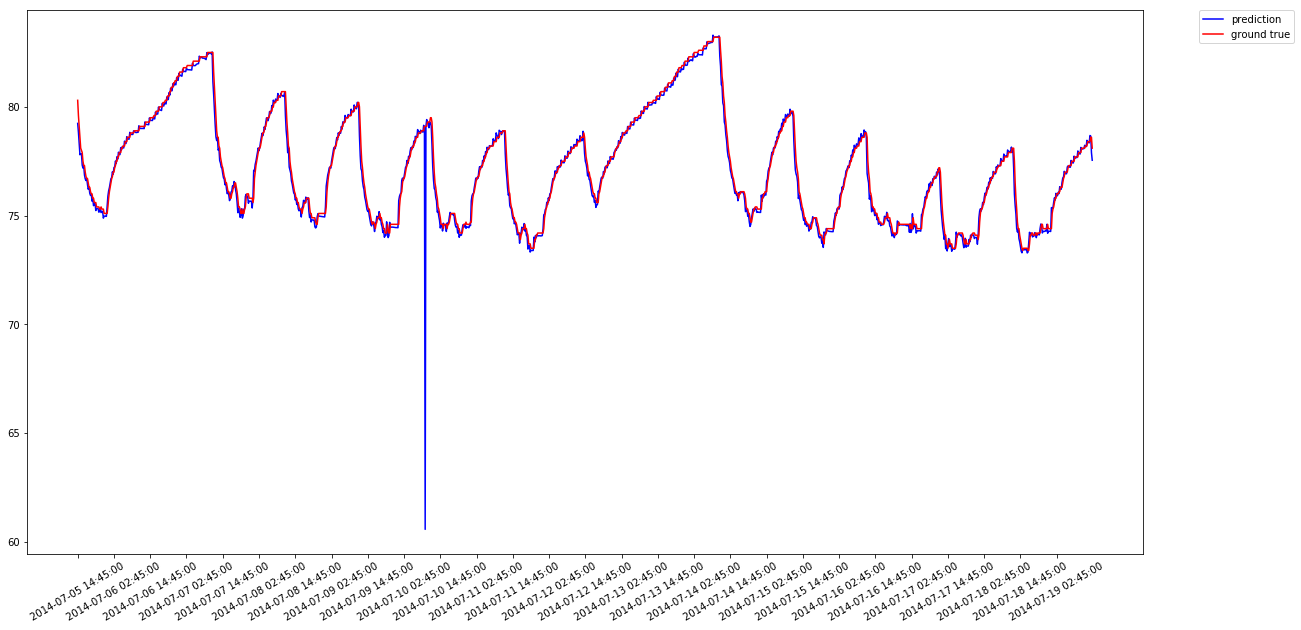

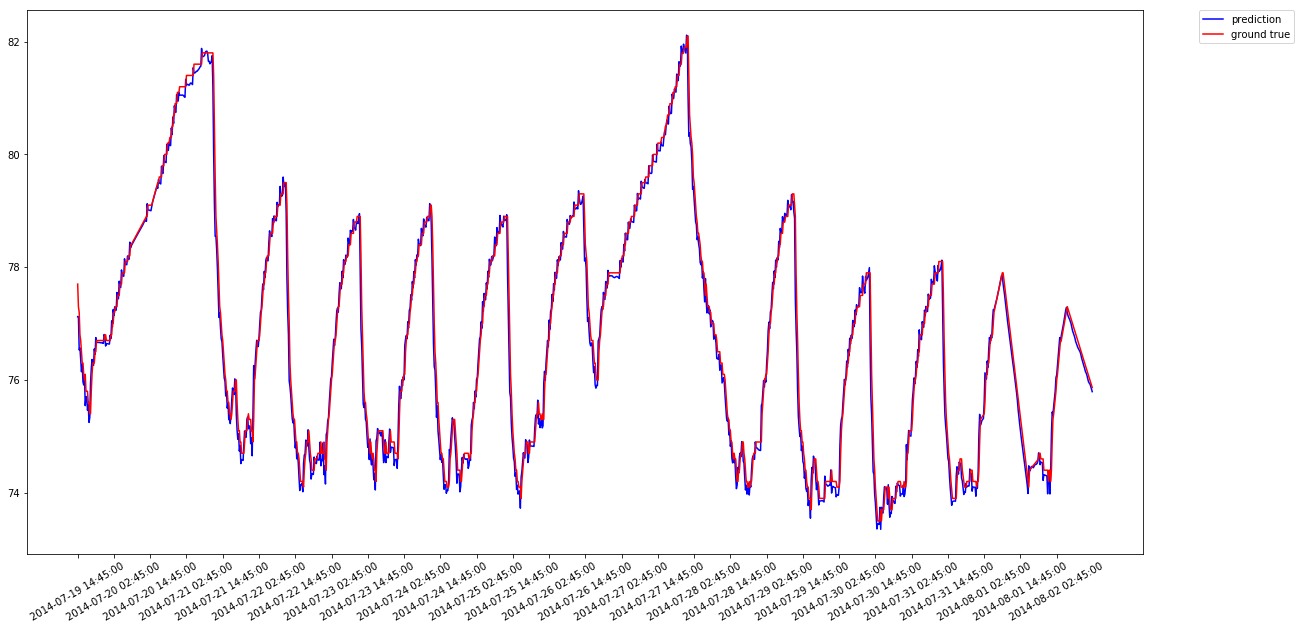

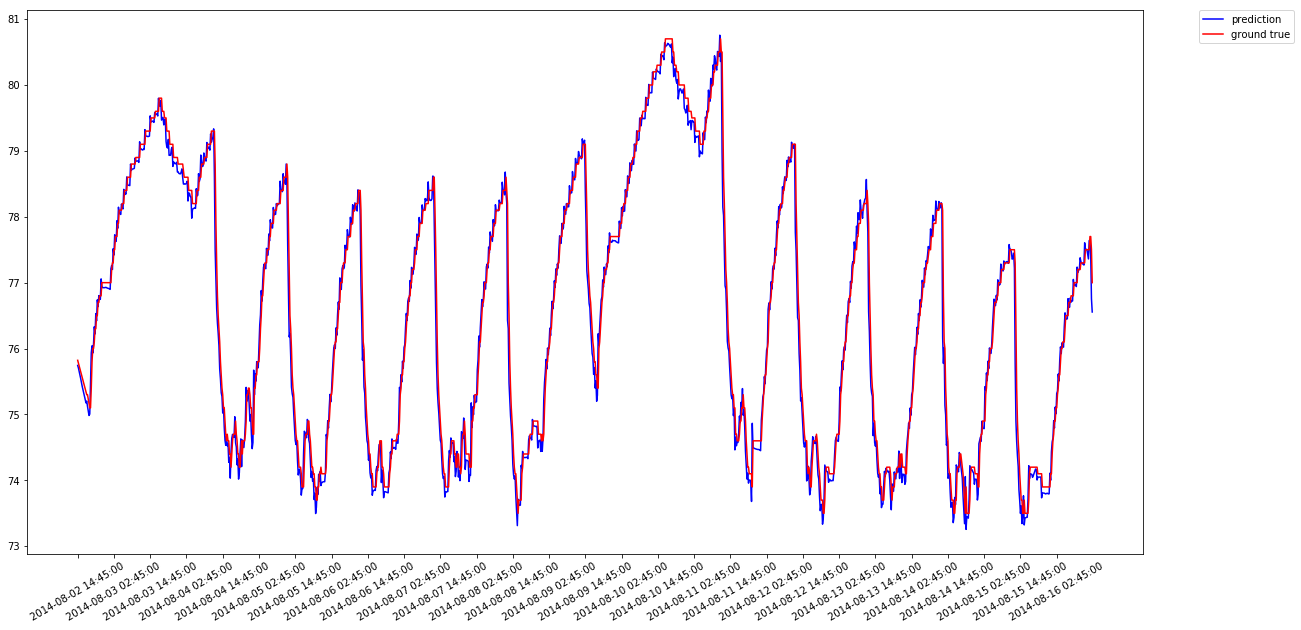

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_num = 24 * 7 * 4 * 2
SHOW_FREQUENT = 12 * 4
x_index = range(plot_num)
x_stick = list(range(0, plot_num, SHOW_FREQUENT))

#for i in range(int(y_labels_arr_decoder_forecast.shape[0] / plot_num)):
for i in range(3):
    start_idx = i * plot_num
    end_idx = (i + 1) * plot_num
    plt.figure(figsize=(20, 10))
    #plt.ylim([72.0, 82.0])
    plt.xticks(x_stick, time_batch_decoder_forecast[[start_idx + x_stick_value for x_stick_value in x_stick]])
    plt.xticks(rotation=30)
    plt.plot(range(plot_num), y_hat_arr_decoder_forecast[start_idx:end_idx, 1], 'b', label="prediction")
    plt.plot(range(plot_num), y_labels_arr_decoder_forecast[start_idx:end_idx, 0], 'r', label="ground true")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.draw()